# Noisy Labels Lead To Incorrect Predictions

![](https://miro.medium.com/max/2720/0*ZGkRWDDZQGHJCvBT)

Hi everyone, today I'll be going through with you my method of denoising the data in this competition. As you know, a significant portion of images in this competition was mislabelled, which is what we know as "label noise". With label noise, it is very likely that your model will pick up the wrong information and make incorrect predictions. For example, if it correctly predicts a dog as a dog, but we tell it that the dog is actually a cat, then it will learn (incorrectly) that features of a dog are supposed to be features of a cat.

Here is the brief overview of this walkthrough:

1. Importing Libraries And Data
2. Image Augmentation
3. Model Building
4. Stratified 5-Fold Cross Validation
5. Retrieving Out-Of-Fold Accuracy and Predictions
6. Test Time Augmentation
7. Denoising The Data
8. Re-Fitting The Model 

*Disclaimer: This method is not backed by any research or empirical evidence. It worked for me and I just wanted to share with the community something I felt would be helpful.*

# Importing Libraries and Data

In [1]:
#Seed everything for reproducible results
import random
from numpy.random import seed
from tensorflow.random import set_seed

seed_value = 42
random.seed(seed_value)
seed(seed_value)
set_seed(seed_value)

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import os
import cv2
import sys
from pylab import rcParams
from PIL import Image
from tqdm import tqdm
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from sklearn.model_selection import StratifiedKFold

In [3]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy) #shortens training time by 2x

In [4]:
df_train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
df_train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [5]:
df_train["label"] = df_train["label"].astype(str) #convert to str as we want to use cross entropy loss later
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  object
dtypes: object(2)
memory usage: 334.5+ KB


# Image Augmentation

In [6]:
batch_size=32
image_size=300

input_shape = (image_size, image_size, 3)
target_size = (image_size, image_size)

In [7]:
img_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomCrop(image_size, image_size),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.25),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
    ])

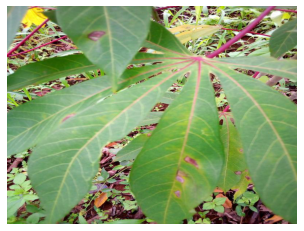

In [80]:
path = "../input/cassava-leaf-disease-classification/train_images/"
files = df_train["image_id"].tolist()
file = random.choice(files)
image = Image.open(path + file)
plt.imshow(image)
plt.axis("off")
plt.show()

Augmentation is necessary as it helps our model generalize better. Let's see what our images can look like after augmentation. 

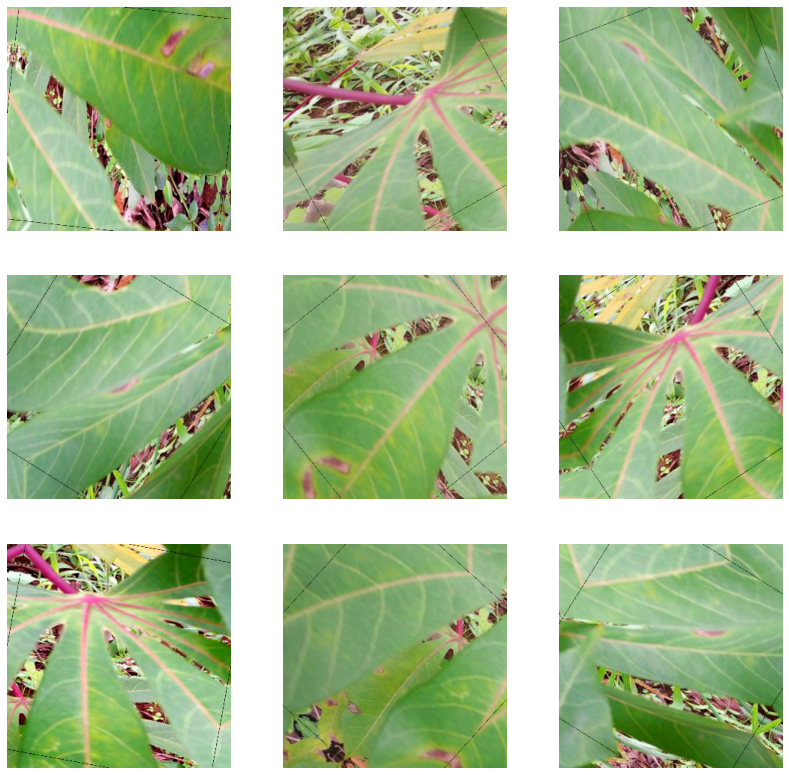

In [81]:
image = tf.expand_dims(np.array(image), 0)

plt.figure(figsize=(14, 14))
for i in range(9):
    augmented_image = img_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

In [10]:
def DataGenerator(train_set, val_set):
    
    train_datagen = ImageDataGenerator().flow_from_dataframe(
                  dataframe = train_set,
                  directory='../input/cassava-leaf-disease-classification/train_images',
                  x_col='image_id',
                  y_col='label',
                  target_size=target_size,
                  batch_size=batch_size,
                  shuffle=True,
                  class_mode='sparse',
                  seed=seed_value)

    val_datagen = ImageDataGenerator().flow_from_dataframe(
                dataframe = val_set,
                directory='../input/cassava-leaf-disease-classification/train_images',
                x_col='image_id',
                y_col='label',
                target_size=target_size,
                batch_size=batch_size,
                shuffle=False,
                class_mode='sparse',
                seed=seed_value)
    
    return train_datagen, val_datagen

# Model Building

I selected EfficientNetB0 for this notebook as it's the smallest and fastest pre-trained model I could find. For your own purposes, you should select your best performing architecture. We will use a Cosine Decay Learning Rate Schedule for our model (more intuition on that below).

![](https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png)

We want a relatively high initial learning rate as we want the loss function to converge to a global minimum (visualized on a 2D plane as the bottom of a curve) as soon as possible. However, as it converges, the gradient might change, requiring a lower learning rate to ensure an optimal learning rate for convergence. Hence, we can't have a fixed learning rate as the initial learning rate may become too high, preventing convergence (as shown in the diagram above). So, we will implement a decay schedule for our learning rate, so that it decreases over time to ensure convergence. 

![](https://miro.medium.com/max/1266/1*2NAuh6DbcrrMv4Voq5yG9A.png)

And this is how our learning rate will look like over time after implementing the decay.

In [11]:
epochs = 3
total_steps = (int(len(df_train)*0.8/batch_size)+1)*epochs

lr = tf.keras.experimental.CosineDecay(initial_learning_rate=1e-3, decay_steps=total_steps)

In [12]:
def build_model():
    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=input_shape)

    # Rebuild top
    inputs = Input(shape=input_shape)
    base = base_model(inputs)
    pooling = GlobalAveragePooling2D()(base)
    outputs = Dense(5, activation="softmax", dtype='float32')(pooling) #necessary for mixed-precision training to work properly

    # Compile
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model

# Stratified 5-Fold Cross Validation

As we are using out-of-fold (OOF) accuracy as the baseline to denoise our data, this part is especially important. Make sure you use 5-fold CV to ensure that your model has a 80/20 training/validation split, with each validation split being a different subset of the entire data. So after 5 folds, your model would have used all the data as validation data, which we can then use to retrieve our OOF accuracy. Stratified KFold helps preserve the class imbalance across all folds, standardizing the difficulty.

In [13]:
fold_number = 0
n_splits = 5
oof_accuracy = []

tf.keras.backend.clear_session()
skf = StratifiedKFold(n_splits=n_splits, random_state=seed_value)
for train_index, val_index in skf.split(df_train["image_id"], df_train["label"]):
    train_set = df_train.loc[train_index]
    val_set = df_train.loc[val_index]
    train_datagen, val_datagen = DataGenerator(train_set, val_set)
    model = build_model()
    print("Training fold no.: " + str(fold_number+1))

    model_name = "effnetb0 "
    fold_name = "fold.h5"
    filepath = model_name + str(fold_number+1) + fold_name
    callbacks = [ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True)]

    history = model.fit(train_datagen, epochs=epochs, validation_data=val_datagen, callbacks=callbacks)
    oof_accuracy.append(max(history.history["val_accuracy"]))
    fold_number += 1
    if fold_number == n_splits:
        print("Training finished!")

Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.
16711680/16705208 [==============================] - 0s 0us/step
Training fold no.: 1
Epoch 1/3
535/535 [==============================] - 339s 634ms/step - loss: 0.5656 - accuracy: 0.8021 - val_loss: 0.4908 - val_accuracy: 0.8376
Epoch 2/3
535/535 [==============================] - 252s 472ms/step - loss: 0.3591 - accuracy: 0.8762 - val_loss: 0.4438 - val_accuracy: 0.8493
Epoch 3/3
535/535 [==============================] - 250s 467ms/step - loss: 0.1804 - accuracy: 0.9395 - val_loss: 0.4499 - val_accuracy: 0.8607
Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.
Training fold no.: 2
Epoch 1/3
535/535 [==============================] - 253s 474ms/step - loss: 0.5819 - accuracy: 0.7962 - val_loss: 0.5266 - val_accuracy: 0.8213
Epoch 2/3
535/535 [==============================] - 249s 465ms/ste

# Retrieving Out-Of-Fold Accuracy
After this, we can see what's our average OOF accuracy:

In [54]:
print("Average Out-Of-Fold Accuracy: {:.2f}".format(np.mean(oof_accuracy)))

Average Out-Of-Fold Accuracy:  0.87


Now to retrieve our OOF predictions, we have to load each model and get them to predict the validation data from their fold.

In [57]:
# First we load our models
models = [] 
for i in range(5):
    effnet = load_model("./effnetb0 " + str(i+1) + "fold.h5")
    models.append(effnet)

model_one = models[0]
model_two = models[1]
model_three = models[2]
model_four = models[3]
model_five = models[4]

In [20]:
# Then we get our validation data
df = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
val_list = []

skf = StratifiedKFold(n_splits=5, random_state=seed_value)
for train_index, val_index in skf.split(df["image_id"], df["label"]):
    val_list.append(val_index)

one_fold = df.loc[val_list[0]]
two_fold = df.loc[val_list[1]]
three_fold = df.loc[val_list[2]]
four_fold = df.loc[val_list[3]]
five_fold = df.loc[val_list[4]]

# Test Time Augmentation

Test Time Augmentation (TTA), is as the name suggests: performing augmentations on your test images before getting your model to predict them. The augmentations are usually (part of) the augmentations you used during training time. This generally leads to a slight performance boost. Here's a brief intuition why: 

When we use softmax cross entropy for multi-class classification, the predictions are usually produced in the form of one-hot labels. That is to say, in the context of this competition, if my model predicts with an 60% confidence that an image is label 3, 30% confidence that the image is label 4, and 10% that the image is label 1, then the one-hot prediction would be like this: [0, 0.1, 0.0, 0.6, 0.3]

During TTA, we duplicate the original image and perform augmentation and get the model to aggregrate predictions across those images, leading to better generalization (refer to figure below).

![](https://stepup.ai/content/images/2020/08/test_time_augmentation_concept.png)

Great, now that we have the intuition, let's define some custom functions for this to work.

In [38]:
tta = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.25),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
    ]
)

In [39]:
def duplicate_image(img_path, image_size=image_size, tta_runs=2):

    img = Image.open(img_path)
    img = img.resize((image_size, image_size))
    img_height, img_width = img.size
    img = np.array(img)
    
    img_list = []
    for i in range(tta_runs):
        img_list.append(img)
  
    return np.array(img_list)

In [40]:
def predict_with_tta(image_filename, folder, tta_runs=2):
    
    #apply TTA to each of the 3 images and sum all predictions for each local image
    localised_predictions = []
    local_image_list = duplicate_image(folder+image_filename)
    for local_image in local_image_list:
        local_image = tf.expand_dims(local_image,0)
        augmented_images = [tta(local_image) for i in range(tta_runs)]
        predictions = model.predict(np.array(augmented_images[0]))
        localised_predictions.append(np.sum(predictions, axis=0))
    
    #sum all predictions from all 3 images and retrieve the index of the highest value
    global_predictions = np.sum(np.array(localised_predictions),axis=0)
    max_value = max(global_predictions)
    final_prediction = np.argmax(global_predictions)
    
    return [final_prediction, max_value, global_predictions]

Let's take a look at how this works out!

In [52]:
train_folder = "../input/cassava-leaf-disease-classification/train_images/"
train_image = "1000015157.jpg"
predictions = predict_with_tta(train_image, train_folder)

print("Predicted Label: ", predictions[0])
print("Predicted Label Value: ", predictions[1])
print("Predicted One-Hot Label: ", predictions[2])

Predicted Label:  4
Predicted Label Value:  1.3470304
Predicted One-Hot Label:  [0.12970969 0.36089987 0.07771565 0.08464444 1.3470304 ]


Very nice. If you realize, the predicted label value is >1 because we implemented 2x TTA. This pushes the max label value (100% confidence) to 2. If you implement 3x TTA, it will be 3 and so on.

Also, this is a percentage estimated as a float. If you want to know how confident in the prediction the model is, simply take the label value/number of tta*100. For example..

In [53]:
print("Confidence Level: {:.2f}".format(predictions[1]/2*100), "%")

Confidence Level:  67.35 %


# Retrieving Out-Of-Fold Predictions

In [55]:
def predict_image_list(image_list, folder):
    predictions = []
    values = []
    with tqdm(total=len(image_list)) as pbar:
        for image_filename in image_list:
            pbar.update(1)
            predictions.append(predict_with_tta(image_filename, folder)[0])
            values.append(predict_with_tta(image_filename, folder)[1])
    return [predictions, values]

In [58]:
model = model_one
placeholder = predict_image_list(one_fold["image_id"], train_folder)
one_fold["pred"] = placeholder[0]
one_fold["value"] = placeholder[1]
one_fold.head()

100%|██████████| 4280/4280 [18:48<00:00,  3.79it/s]


,image_id,label,pred,value
0,1000015157.jpg,0,1,1.146353
1,1000201771.jpg,3,3,1.994797
2,100042118.jpg,1,4,1.967927
3,1000723321.jpg,1,1,1.903441
4,1000812911.jpg,3,3,1.999994


In [59]:
model = model_two
placeholder = predict_image_list(two_fold["image_id"], train_folder)
two_fold["pred"] = placeholder[0]
two_fold["value"] = placeholder[1]
two_fold.head()

100%|██████████| 4280/4280 [18:49<00:00,  3.79it/s]


,image_id,label,pred,value
4152,1741376467.jpg,2,2,1.964881
4160,1742921296.jpg,2,3,1.978662
4165,1744132907.jpg,2,2,1.092813
4170,1745213235.jpg,2,2,1.969668
4186,1748078047.jpg,2,3,0.754145


In [60]:
model = model_three
placeholder = predict_image_list(three_fold["image_id"], train_folder)
three_fold["pred"] = placeholder[0]
three_fold["value"] = placeholder[1]
three_fold.head()

100%|██████████| 4279/4279 [19:16<00:00,  3.70it/s]


,image_id,label,pred,value
8381,248855703.jpg,2,2,1.998454
8384,2488945331.jpg,2,2,1.995100
8403,2491752039.jpg,2,2,1.208200
8407,2492550594.jpg,2,1,1.230652
8416,2494764703.jpg,2,2,1.983111


In [61]:
model = model_four
placeholder = predict_image_list(four_fold["image_id"], train_folder)
four_fold["pred"] = placeholder[0]
four_fold["value"] = placeholder[1]
four_fold.head()

100%|██████████| 4279/4279 [19:14<00:00,  3.71it/s]


,image_id,label,pred,value
12789,3290333742.jpg,2,2,1.233624
12795,3292343702.jpg,2,3,1.151819
12801,3293012629.jpg,2,2,1.996029
12810,3294433487.jpg,1,4,1.569324
12813,329471118.jpg,1,1,1.473392


In [62]:
model = model_five
placeholder = predict_image_list(five_fold["image_id"], train_folder)
five_fold["pred"] = placeholder[0]
five_fold["value"] = placeholder[1]
five_fold.head()

100%|██████████| 4279/4279 [19:27<00:00,  3.67it/s]


,image_id,label,pred,value
16944,4048377608.jpg,2,2,1.995229
16951,4049425598.jpg,2,3,1.862021
16954,4049743612.jpg,2,2,1.988796
16956,4050218395.jpg,2,2,1.998631
16958,4050718274.jpg,2,4,1.086706


# Denoising The Data

So what we need to do now is to set a confidence level (or threshold) for our model to clean the labels. Here is how we are going to do it:

1. Identify the images which our model predicted incorrectly
2. Determine if the confidence level is above our threshold
3. If it is, remove or relabel the data
4. If not, leave it as it is

The brief intuition behind why this works is because your model is already predicting wrong labels with very high confidence for those images. Hence, it is unlikely to predict it correctly even if you continue to feed it the image for training (as it is unable to get it right anyway). Thus, by removing these noisy labels, it can then focus on the correct labels and strengthen its predictions on the clean data. 

Of course, you do not want to remove so much data that it is unable to "learn" the "difficult" examples, or worse, change the distribution of the dataset. For demonstration purposes, I will set this threshold at 80% confidence.

In [63]:
threshold = 2*0.8

We will then retrieve the index of the selected images to be "denoised" and combine them into a list.

In [64]:
mask1 = (one_fold["label"] != one_fold["pred"]) & (one_fold["value"] >= threshold)
one_list = one_fold[mask1].index.to_list()

mask2 = (two_fold["label"] != two_fold["pred"]) & (two_fold["value"] >= threshold)
two_list = two_fold[mask2].index.to_list()

mask3 = (three_fold["label"] != three_fold["pred"]) & (three_fold["value"] >= threshold)
three_list = three_fold[mask3].index.to_list()

mask4 = (four_fold["label"] != four_fold["pred"]) & (four_fold["value"] >= threshold)
four_list = four_fold[mask4].index.to_list()

mask5 = (five_fold["label"] != five_fold["pred"]) & (five_fold["value"] >= threshold)
five_list = five_fold[mask5].index.to_list()

combined_list = list(np.unique(one_list + two_list + three_list + four_list + five_list))

Let's take a look at the distribution of this list.

In [66]:
temp = df_train.iloc[combined_list]
temp["label"].value_counts()

2    368
4    213
1    160
0    142
3    136
Name: label, dtype: int64

In [70]:
pct = len(temp)/len(df_train)*100
print("Percentage of Data To Be Removed: {:.2f}".format(pct), "%")

Percentage of Data To Be Removed: 4.76 %


# Re-Fitting The Model
We will now drop these images from our dataset and see how it affects the performance of our model.

In [71]:
df = df_train.drop(combined_list, axis="index")

In [73]:
df.reset_index(drop=True, inplace=True)

In [75]:
fold_number = 0
n_splits = 5
oof_accuracy = []

tf.keras.backend.clear_session()
skf = StratifiedKFold(n_splits=n_splits, random_state=seed_value)
for train_index, val_index in skf.split(df["image_id"], df["label"]):
    train_set = df.loc[train_index]
    val_set = df.loc[val_index]
    train_datagen, val_datagen = DataGenerator(train_set, val_set)
    model = build_model()
    print("Training fold no.: " + str(fold_number+1))

    model_name = "denoised effnetb0 "
    fold_name = "fold.h5"
    filepath = model_name + str(fold_number+1) + fold_name
    callbacks = [ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True)]

    history = model.fit(train_datagen, epochs=epochs, validation_data=val_datagen, callbacks=callbacks)
    oof_accuracy.append(max(history.history["val_accuracy"]))
    fold_number += 1
    if fold_number == n_splits:
        print("Training finished!")

Found 16302 validated image filenames belonging to 5 classes.
Found 4076 validated image filenames belonging to 5 classes.
Training fold no.: 1
Epoch 1/3
510/510 [==============================] - 258s 506ms/step - loss: 0.4693 - accuracy: 0.8287 - val_loss: 0.4382 - val_accuracy: 0.8614
Epoch 2/3
510/510 [==============================] - 236s 462ms/step - loss: 0.2721 - accuracy: 0.9028 - val_loss: 0.2760 - val_accuracy: 0.8984
Epoch 3/3
510/510 [==============================] - 235s 462ms/step - loss: 0.1185 - accuracy: 0.9576 - val_loss: 0.2910 - val_accuracy: 0.9073
Found 16302 validated image filenames belonging to 5 classes.
Found 4076 validated image filenames belonging to 5 classes.
Training fold no.: 2
Epoch 1/3
510/510 [==============================] - 243s 476ms/step - loss: 0.4632 - accuracy: 0.8324 - val_loss: 0.4095 - val_accuracy: 0.8668
Epoch 2/3
510/510 [==============================] - 241s 473ms/step - loss: 0.2629 - accuracy: 0.9044 - val_loss: 0.2899 - val_accu

In [76]:
print("Average Out-Of-Fold Accuracy: {:.2f}".format(np.mean(oof_accuracy)))

Average Out-Of-Fold Accuracy: 0.90


As you can see, just by removing less than 5% of the data, our CV increased significantly. Of course, a fairer comparison would be to keep the original validation splits, but that would require several more lines of code. Personally, I got a 0.01 LB increase after denoising the labels this way, so I hope this will help you too! If you liked this notebook, please give it an upvote. It motivates me to continue to make high-quality notebooks. Do check out my other notebook where I cover an end-to-end solution in Keras for this competition too: https://www.kaggle.com/junyingsg/end-to-end-cassava-disease-classification-in-keras

Some of my other notebooks unrelated to this competition:
- https://www.kaggle.com/junyingsg/in-depth-analysis-of-women-s-e-commerce-reviews
- https://www.kaggle.com/junyingsg/a-clean-analysis-of-covid-19-data
- https://www.kaggle.com/junyingsg/a-beginner-s-comprehensive-guide-to-using-xgboost

Thanks for the support & happy kaggling!